In [1]:
from google.colab import drive
drive.mount('/content/drive/')
import os
os.chdir('/content/drive/My Drive/02620')

Mounted at /content/drive/


In [2]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt

In [3]:
luad = pd.read_csv('TCGA-LUAD.htseq_fpkm.tsv', sep='\t').transpose()

In [4]:
gene_names = luad.loc['Ensembl_ID']

In [5]:
luad = luad.iloc[1: , :]

In [6]:
luad = luad.set_axis(gene_names, axis = 1)

In [7]:
luad.head()

Ensembl_ID,ENSG00000242268.2,ENSG00000270112.3,ENSG00000167578.15,ENSG00000273842.1,ENSG00000078237.5,ENSG00000146083.10,ENSG00000225275.4,ENSG00000158486.12,ENSG00000198242.12,ENSG00000259883.1,...,ENSG00000238244.3,ENSG00000186115.11,ENSG00000216352.1,ENSG00000267117.1,ENSG00000273233.1,ENSG00000105063.17,ENSG00000231119.2,ENSG00000280861.1,ENSG00000123685.7,ENSG00000181518.3
TCGA-MP-A4T4-01A,0.046078,0.0,2.423898,0.0,2.40365,3.722587,0.0,1.189987,6.703572,0.200922,...,0.0,0.0,0.0,0.334857,0.0,5.060513,0.205208,0.0,3.016487,0.0
TCGA-05-4250-01A,0.030502,0.0,1.793365,0.0,1.974839,3.772691,0.0,0.21693,8.174492,0.186172,...,0.0,0.006949,0.0,0.095996,0.0,3.647831,0.488053,0.0,1.564234,0.0
TCGA-64-5774-01A,0.0,0.006586,1.653847,0.0,2.638665,3.856023,0.0,1.206831,7.839614,0.0,...,0.0,0.01071,0.0,0.14558,0.0,4.397029,0.271508,0.0,1.602433,0.0
TCGA-97-7937-01A,0.0,0.0,2.457264,0.0,2.375219,3.245244,0.0,0.124161,6.954493,0.034526,...,0.0,0.008549,0.0,0.420889,0.0,3.814975,1.314095,0.0,0.755575,0.0
TCGA-97-A4M6-01A,0.0,0.006266,2.577046,0.0,1.961834,4.302133,0.0,0.362731,6.598758,0.15776,...,0.0,0.0,0.0,0.324844,0.0,3.838989,0.681049,0.0,1.98984,0.0


In [8]:
luad.shape

(585, 60483)

In [9]:
luad = luad.astype('float64', copy = False)

In [10]:
sample_name = []
for row in luad.index:
    sample_name.append(row)


In [11]:
y = []
for s in sample_name:
  if s[-3:] == '11A':
    y.append(1)
  else:
    y.append(0)


In [12]:
sum(y)

58

In [13]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
select = SelectKBest(score_func=chi2, k=4536)
luad = select.fit_transform(luad,y)

In [14]:
luad.shape

(585, 4536)

In [15]:
n_feature = luad.shape[1]

In [16]:
from sklearn import model_selection
x_train,x_test,y_train,y_test= model_selection.train_test_split(luad,
                                                y,
                                                test_size=0.2,
                                                random_state=3,
                                                stratify=y,
                                                shuffle=True)

In [17]:
x_train.shape

(468, 4536)

In [18]:
from collections import Counter
count=Counter(y_train)
class_count=np.array([count[0],count[1]])
weight=1./class_count
print(weight)

[0.00236967 0.02173913]


In [19]:
samples_weight = np.array([weight[t] for t in y_train])

In [20]:
samples_weight=torch.from_numpy(samples_weight)

In [21]:
sampler = torch.utils.data.sampler.WeightedRandomSampler(samples_weight, len(samples_weight))

In [22]:
batch_size = 10

In [23]:
trainDataset = torch.utils.data.TensorDataset(torch.FloatTensor(x_train), torch.LongTensor(y_train))
validDataset = torch.utils.data.TensorDataset(torch.FloatTensor(x_test), torch.LongTensor(y_test))
trainLoader = torch.utils.data.DataLoader(dataset = trainDataset, batch_size=batch_size, num_workers=1, sampler = sampler)
testLoader = torch.utils.data.DataLoader(dataset = validDataset, batch_size=batch_size, shuffle=False, num_workers=1)

In [24]:
import torch.nn.functional as F

In [25]:
class predictor(torch.nn.Module):
    def __init__(self,n_input,n_output):
        super().__init__()
        self.hidden1 = torch.nn.Linear(n_input,n_input//8)
        self.hidden2 = torch.nn.Linear(n_input//8,n_input//16)
        self.hidden3 = torch.nn.Linear(n_input//16,n_output)
    def forward(self, input):
        out = self.hidden1(input)
        out = torch.sigmoid(out)
        out = self.hidden2(out)
        out = torch.sigmoid(out)
        out = self.hidden3(out)
        return out

In [26]:
model = predictor(n_feature,  2)
cuda0 = torch.device('cuda:0')
model = model.to(cuda0)

In [27]:
optimizer = torch.optim.Adam(model.parameters(),lr=1e-5)
criterion = torch.nn.CrossEntropyLoss()


In [28]:
from IPython.display import clear_output
def draw_pics(loss_test_list, loss_train_list, acc_test_list, acc_train_list):
    clear_output(wait=True)
    fig,a =  plt.subplots(1,2, figsize=(24,10))

    a[0].plot(loss_test_list, label = 'Test set')
    a[0].plot(loss_train_list, label = 'Training set')
    a[0].set_title('Loss')
    a[0].legend(loc="upper right")
    
  

    a[1].plot(acc_test_list, label = 'Test set')
    a[1].plot(acc_train_list, label = "Training set")
    a[1].set_title('Accuracy')
    a[1].legend(loc="upper right")

    plt.show()

In [29]:
def evaluate_loss(model, criterion, testLoader, trainLoader):
    model.eval()
    with torch.no_grad():
      loss_test = []
      loss_train = []
      for batch_test in testLoader:
          prediction = model(F.normalize(batch_test[0]).to(cuda0))
          loss_test.append(criterion(prediction, batch_test[1].to(cuda0)))
      for batch_train in trainLoader:
          prediction = model(F.normalize(batch_train[0]).to(cuda0))
          loss_train.append(criterion(prediction, batch_train[1].to(cuda0)))  
    loss_test_epoch = sum(loss_test) /len(loss_test)
    loss_train_epoch = sum(loss_train)/len(loss_train)
    return loss_test_epoch, loss_train_epoch

In [30]:
def evaluate_accuracy(model, criterion, testLoader, trainLoader):
    model.eval()
    with torch.no_grad():
      acc_test = []
      acc_train = []
      for batch_test in testLoader:
          prediction = model(F.normalize(batch_test[0]).to(cuda0))
          binary_pre = []
          for i in range(len(prediction)):
              if prediction[i,0] > prediction[i,1]:
                  binary_pre.append(0)
              else:
                  binary_pre.append(1)
          y = batch_test[1].cpu().detach().numpy()
          binary_pre = np.array(binary_pre)
          accuracy = sum(binary_pre==y)/len(y)
          acc_test.append(accuracy)
      for batch_train in trainLoader:
          prediction = model(F.normalize(batch_train[0]).to(cuda0))
          binary_pre = []
          for i in range(len(prediction)):
              if prediction[i,0] > prediction[i,1]:
                  binary_pre.append(0)
              else:
                  binary_pre.append(1)
          y = batch_train[1].cpu().detach().numpy()
          binary_pre = np.array(binary_pre)
          accuracy = sum(binary_pre==y)/len(y)
          acc_train.append(accuracy)
      return sum(acc_test)/len(acc_test), sum(acc_train)/len(acc_train)
      



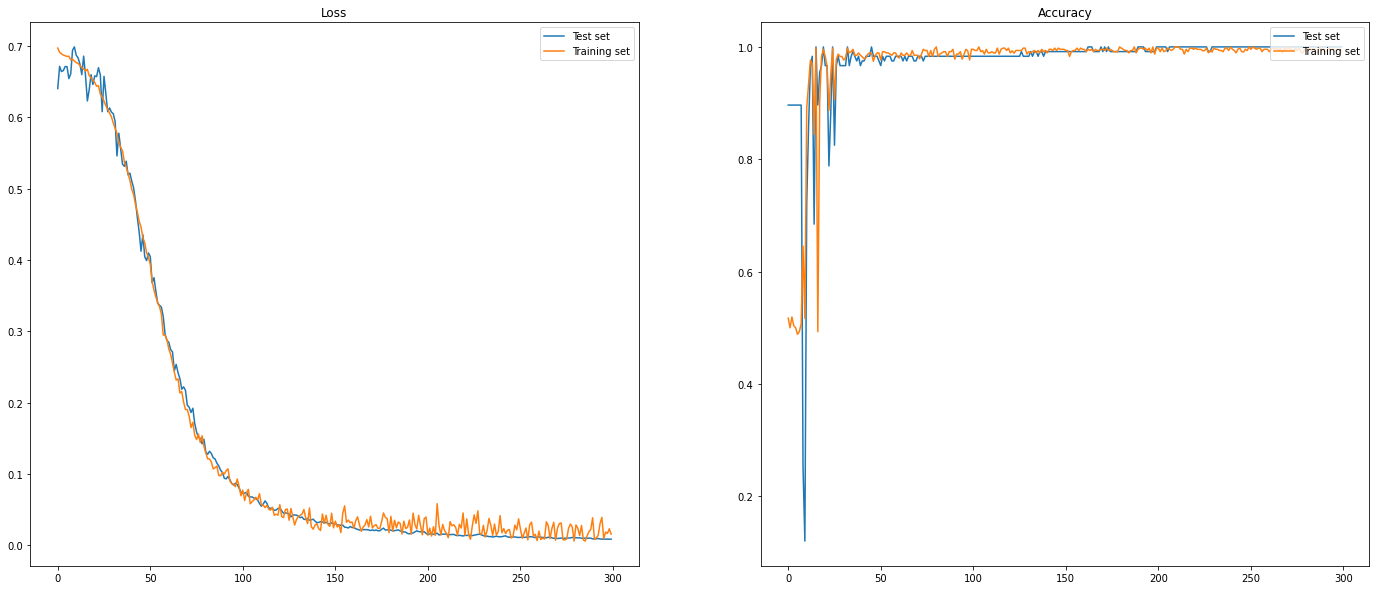

In [31]:

num_epochs = 300
loss_test_all = []
loss_train_all = []
acc_test_all = []
acc_train_all = []
for epoch in range(num_epochs):
    model.train()
    for idx, batch in enumerate(trainLoader):
        batch_x = F.normalize(batch[0])
        batch_x = batch_x.to(cuda0)
        batch_y = batch[1].to(cuda0)
        prediction = model(batch_x)

        loss = criterion(prediction, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    
    loss_test_epoch, loss_train_epoch =evaluate_loss(model, criterion, testLoader, trainLoader)
    loss_test_all.append(loss_test_epoch.item())
    loss_train_all.append(loss_train_epoch.item())
    acc_test_epoch, acc_train_epoch = evaluate_accuracy(model, criterion, testLoader, trainLoader)
    acc_test_all.append(acc_test_epoch)
    acc_train_all.append(acc_train_epoch)

    draw_pics(loss_test_all, loss_train_all, acc_test_all, acc_train_all)
    

In [32]:
model.to('cpu')
model.eval()
prediction = model(F.normalize(torch.tensor(luad[:,0:n_feature])).float())

In [33]:
binary_pre = []
for i in range(len(prediction)):
    if prediction[i,0] > prediction[i,1]:
        binary_pre.append(0)
    else:
        binary_pre.append(1)

In [34]:
binary_pre = np.array(binary_pre)
y = np.array(y)
accuracy = sum(binary_pre==y)/len(y)
print(accuracy)

0.9931623931623932


In [35]:
test_iter = iter(testLoader)
init = next(test_iter)
test_x = init[0]
test_y = init[1]
for i in test_iter:
    test_x = torch.cat((test_x, i[0]))
    test_y = torch.cat((test_y, i[1]))
test_y = test_y.tolist()
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, matthews_corrcoef
from sklearn.metrics import roc_auc_score, average_precision_score
from prettytable import PrettyTable
import warnings
prediction_2 = model(F.normalize(test_x).float())
binary_pre_2 = []
for i in range(len(prediction_2)):
    if prediction_2[i,0] > prediction_2[i,1]:
        binary_pre_2.append(0)
    else:
        binary_pre_2.append(1)
accuracy_scores = []
f1_scores = []
recall_scores = []
precision_scores = []
MCCs = []
auROCs = []
auPRCs = []

accuracy_scores.append(accuracy_score(y_true=test_y, y_pred= binary_pre_2))
f1_scores.append(f1_score(y_true=test_y, y_pred= binary_pre_2))
recall_scores.append(recall_score(y_true=test_y, y_pred= binary_pre_2))
precision_scores.append(precision_score(y_true=test_y, y_pred= binary_pre_2))
MCCs.append(matthews_corrcoef(y_true=test_y, y_pred= binary_pre_2))
# auROCs.append(roc_auc_score(y_true=y_test, y_score=clf.predict_sample(X_test,clf.Tree)[:, 1]))
# auPRCs.append(average_precision_score(y_true=y_test, y_score=clf.predict_proba(X_test)[:, 0]))

table = PrettyTable()
column_names = ['Accuracy', 'auROC', 'auPRC', 'recall', 'precision', 'f1', 'MCC']
table.add_column(column_names[0], np.round(accuracy_scores, 4))
# table.add_column(column_names[1], np.round(auROCs, 4))
# table.add_column(column_names[2], np.round(auPRCs, 4))
table.add_column(column_names[3], np.round(recall_scores, 4))
table.add_column(column_names[4], np.round(precision_scores, 4))
table.add_column(column_names[5], np.round(f1_scores, 4))
table.add_column(column_names[6], np.round(MCCs, 4))

print(table)

+----------+--------+-----------+-----+-----+
| Accuracy | recall | precision |  f1 | MCC |
+----------+--------+-----------+-----+-----+
|   1.0    |  1.0   |    1.0    | 1.0 | 1.0 |
+----------+--------+-----------+-----+-----+
